In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import ROOT
import pylhe
import heapq
import os
from multiprocessing import Pool

Welcome to JupyROOT 6.20/04


In [2]:
data1=pylhe.readLHE("/root/MG5_aMC_v2_7_3/Alp/Events/run_01/unweighted_events.lhe")
event_list1 = []
for event1 in data1:
    event_list1.append(event1)
print('{:^12}{:^9}{:^12}{:^12}{:^12}{:^12}{:^12}{:^12}{:^12}'.format('#','id','mother1','mother2','e','px','py','pz','status'))

for i, element in enumerate(event_list1[100].particles):
    print('{:^12}{:^9.0f}{:^12.0f}{:^12.0f}{:^12.3f}{:^12.3f}{:^12.3f}{:^12.3f}{:^12.0f}'
          .format(i+1, element.id, element.mother1, element.mother2, element.e, element.px, element.py, element.pz, element.status))

     #         id      mother1     mother2        e           px          py          pz        status   
     1          5         0           0         68.816      -0.000      0.000       68.655        -1     
     2          2         0           0        857.655      0.000       -0.000     -857.655       -1     
     3          6         1           2        245.586     -103.787     3.058      -141.575       2      
     4         24         3           3        142.952     -48.317     -62.402     -85.453        2      
     5         -11        4           4         44.942      -8.008      15.358     -41.470        1      
     6         12         4           4         98.010     -40.309     -77.760     -43.982        1      
     7          5         3           3        102.634     -55.470      65.460     -56.122        1      
     8          1         1           2        637.209     125.447      25.233     -624.229       1      
     9       9000005      1           2       

In [3]:
#rapidity
def pr(p):
    pz = getattr(p, 'pz')
    p_total = np.sqrt(getattr(p, 'px')**2 + getattr(p, 'py')**2 + pz**2)

    if p_total == 0:
        return 0
    else:
        pr = 0.5 * np.log((p_total + pz) / (p_total - pz))
        return pr

In [4]:
import os
import numpy as np
import pylhe

def pr(p):
    pz = getattr(p, 'pz')
    p_total = np.sqrt(getattr(p, 'px')**2 + getattr(p, 'py')**2 + pz**2)

    if p_total == 0:
        return 0
    else:
        pr = 0.5 * np.log((p_total + pz) / (p_total - pz))
        return pr

def calculate_phiR(p1, p2):
    phi1 = np.arctan2(p1.py, p1.px)
    phi2 = np.arctan2(p2.py, p2.px)

    phiR = np.abs(phi1 - phi2)
    phiR = np.where(phiR > np.pi, 2 * np.pi - phiR, phiR)

    return phiR

events_dir = "/root/MG5_aMC_v2_7_3/Alp/Events"

def calculate_quantities(run_num):
    events_path = os.path.join(events_dir, "run_{:02d}".format(run_num), "unweighted_events.lhe")
    data = pylhe.readLHE(events_path)

    jet_rapidity_list, ax_rapidity_list, tq_rapidity_list, phiR_list_ax_tq, phiR_list_ax_jet, phiR_list_tq_jet = [], [], [], [], [], []

    for event in data:
        ax_rapidity_list.append(pr(event.particles[-1]))
        tq_rapidity_list.append(pr(event.particles[-7]))
        phiR_list_ax_tq.append(calculate_phiR(event.particles[-1], event.particles[-7]))
        for particle in event.particles:
            if particle.mother1 == 1 and particle.id not in [9000005, 6, -6]:
                jet_rapidity = pr(particle)
                jet_rapidity_list.append(jet_rapidity)
                phiR_list_ax_jet.append(calculate_phiR(event.particles[-1], particle))
                phiR_list_tq_jet.append(calculate_phiR(event.particles[-7], particle))

    Radp1 = np.array(ax_rapidity_list)
    Radp2 = np.array(jet_rapidity_list)
    Radp3 = np.array(tq_rapidity_list)

    phiR_jax = np.array(phiR_list_ax_jet)
    phiR_tax = np.array(phiR_list_ax_tq)
    phiR_jt = np.array(phiR_list_tq_jet)

    phi_axj = phiR_jax
    phi_axt = phiR_tax
    phi_jt = phiR_jt

    ang1 = 2 * np.arctan(np.exp(-Radp1))
    ang2 = 2 * np.arctan(np.exp(-Radp2))
    ang3 = 2 * np.arctan(np.exp(-Radp3))

    deltaR_jax = np.sqrt((Radp2 - Radp1)**2 + (phi_axj)**2)
    deltaR_tax = np.sqrt((Radp3 - Radp1)**2 + (phi_axt)**2)
    deltaR_jt = np.sqrt((Radp2 - Radp3)**2 + (phi_jt)**2)

    return Radp1, Radp2, Radp3, phi_axj, phi_axt, phi_jt, ang1, ang2, ang3, deltaR_jax, deltaR_tax, deltaR_jt

# Define the number of runs
num_runs = 4

# Create lists to store results for all runs
all_Radp1, all_Radp2, all_Radp3, all_phi_axj, all_phi_axt, all_phi_jt, all_ang1, all_ang2, all_ang3, all_deltaR_jax, all_deltaR_tax, all_deltaR_jt = [], [], [], [], [], [], [], [], [], [], [], []

# Loop through each run and store the results
for run_num in range(1, num_runs + 1):
    Radp1, Radp2, Radp3, phi_axj, phi_axt, phi_jt, ang1, ang2, ang3, deltaR_jax, deltaR_tax, deltaR_jt = calculate_quantities(run_num)
    
    all_Radp1.append(Radp1)
    all_Radp2.append(Radp2)
    all_Radp3.append(Radp3)
    all_phi_axj.append(phi_axj)
    all_phi_axt.append(phi_axt)
    all_phi_jt.append(phi_jt)
    all_ang1.append(ang1)
    all_ang2.append(ang2)
    all_ang3.append(ang3)
    all_deltaR_jax.append(deltaR_jax)
    all_deltaR_tax.append(deltaR_tax)
    all_deltaR_jt.append(deltaR_jt)

# Now, you have all the data from multiple runs stored in respective lists


In [5]:
all_phi_axj

[array([1.98620954, 3.08134371, 1.67904438, ..., 2.56682968, 1.93378463,
        0.42529339]),
 array([2.59701912, 2.56146656, 0.06689499, ..., 2.66967638, 2.27060144,
        3.12256263]),
 array([1.93556242, 1.86868268, 2.82865335, ..., 0.86948413, 2.13564244,
        2.90316008]),
 array([0.32171688, 2.63484554, 2.61650119, ..., 1.44995154, 1.45749384,
        1.79330501])]

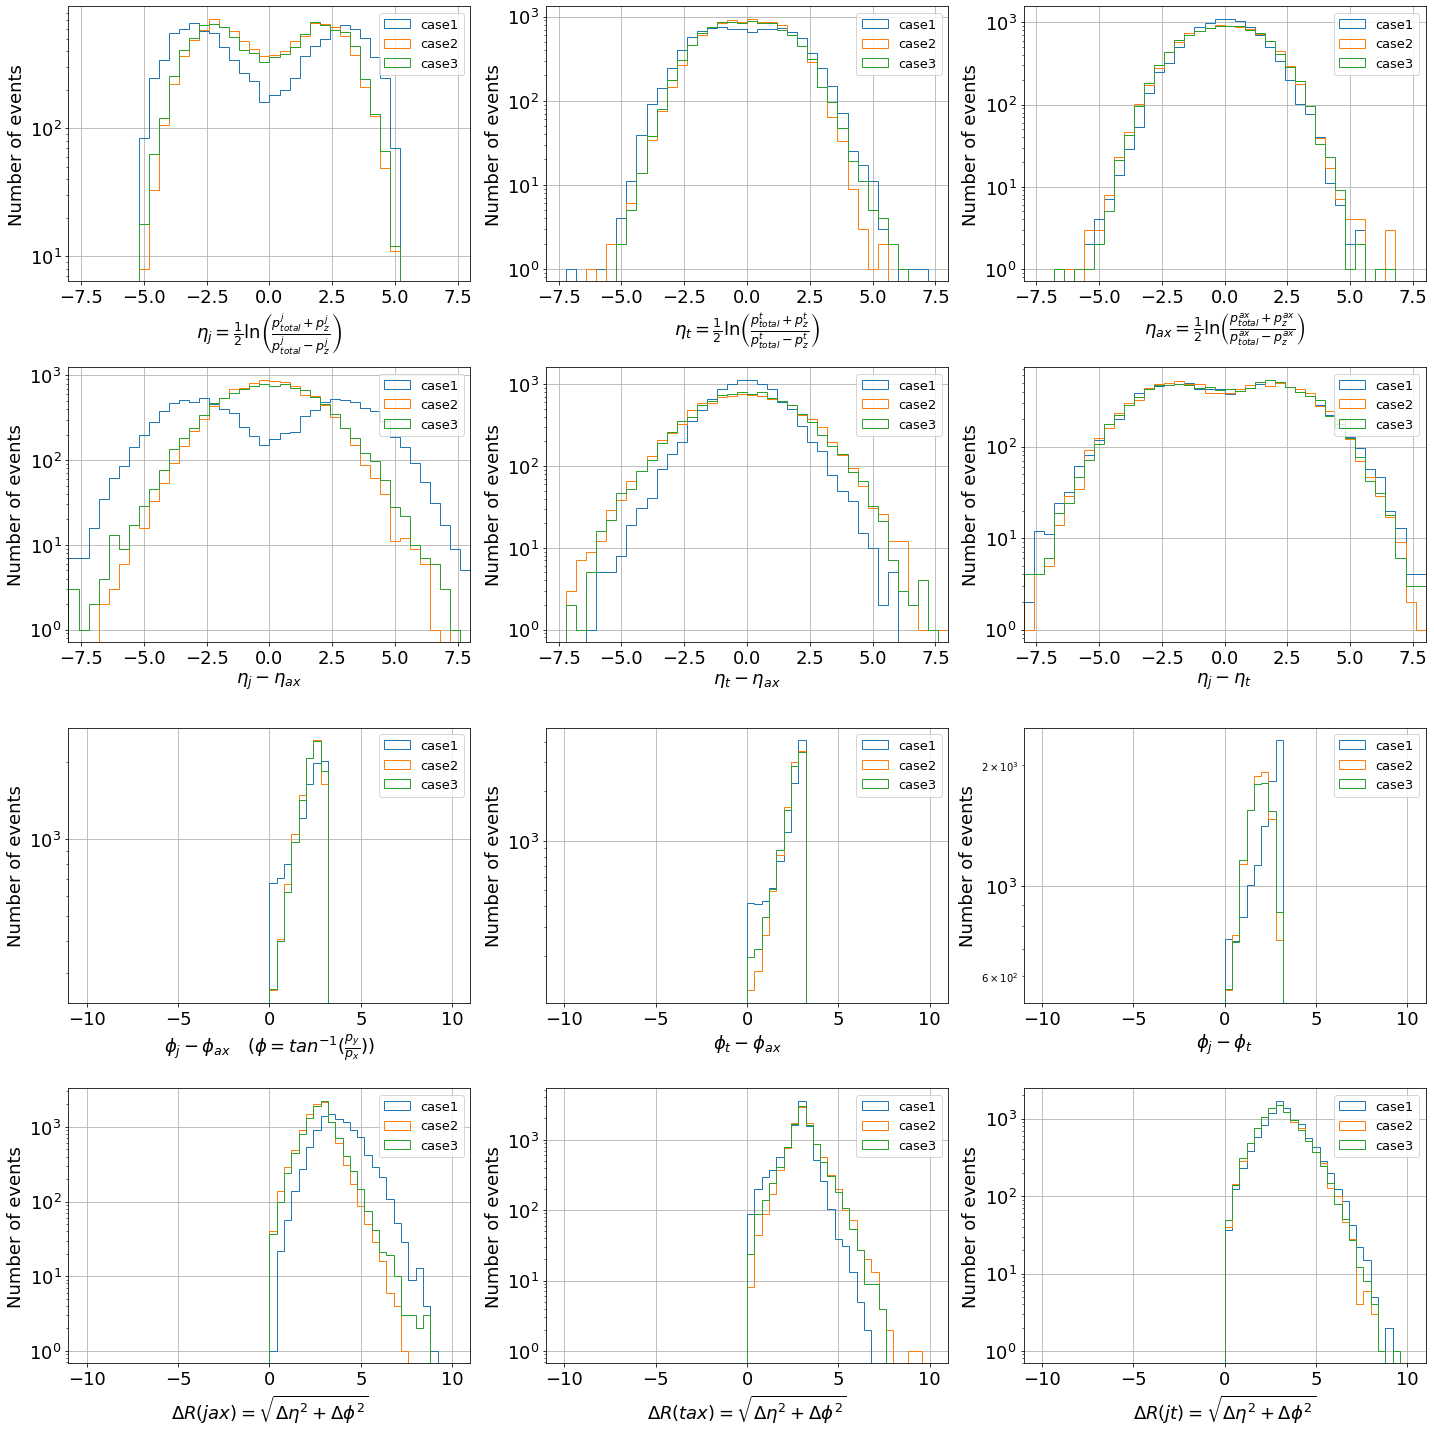

In [8]:
import matplotlib.pyplot as plt

bins = 50
fs = 18  # font size
x1, x2 = -10, 10  # x region
labels = ['case1', 'case2', 'case3']

# Create subplots with 2 rows and 3 columns
fig, axs = plt.subplots(4, 3, figsize=(20, 20))

# Plot the histograms for the first row, first column
axs[0, 0].hist(all_Radp2[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[0, 0].hist(all_Radp2[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[0, 0].hist(all_Radp2[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('$\\eta_j=\\frac{1}{2} \\ln \\left( \\frac{p^j_{total} + p^j_z}{p^j_{total} - p^j_z} \\right)$', fontsize=fs)
axs[0, 0].set_ylabel("Number of events", fontsize=fs)
axs[0, 0].tick_params(labelsize=fs)
axs[0, 0].set_xlim(-8, 8)
axs[0, 0].grid()
axs[0, 0].legend(fontsize=13)

# Plot the histograms for the first row, second column
axs[0, 1].hist(all_Radp3[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[0, 1].hist(all_Radp3[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[0, 1].hist(all_Radp3[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('$\\eta_t=\\frac{1}{2} \\ln \\left( \\frac{p^t_{total} + p^t_z}{p^t_{total} - p^t_z} \\right)$', fontsize=fs)
axs[0, 1].set_ylabel("Number of events", fontsize=fs)
axs[0, 1].tick_params(labelsize=fs)
axs[0, 1].set_xlim(-8, 8)
axs[0, 1].grid()
axs[0, 1].legend(fontsize=13)

# Plot the histograms for the first row, third column
axs[0, 2].hist(all_Radp1[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[0, 2].hist(all_Radp1[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[0, 2].hist(all_Radp1[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[0, 2].set_yscale('log')
axs[0, 2].set_xlabel('$\\eta_{ax}=\\frac{1}{2} \\ln \\left( \\frac{p^{ax}_{total} + p^{ax}_z}{p^{ax}_{total} - p^{ax}_z} \\right)$', fontsize=fs)
axs[0, 2].set_ylabel("Number of events", fontsize=fs)
axs[0, 2].tick_params(labelsize=fs)
axs[0, 2].set_xlim(-8, 8)
axs[0, 2].grid()
axs[0, 2].legend(fontsize=13)

# Plot the histograms for the second row, first column
axs[1, 0].hist(all_Radp2[0]-all_Radp1[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[1, 0].hist(all_Radp2[1]-all_Radp1[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[1, 0].hist(all_Radp2[2]-all_Radp1[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('$\\eta_j-\\eta_{ax}$', fontsize=fs)
axs[1, 0].set_ylabel("Number of events", fontsize=fs)
axs[1, 0].tick_params(labelsize=fs)
axs[1, 0].set_xlim(-8, 8)
axs[1, 0].grid()
axs[1, 0].legend(fontsize=13)

# Plot the histograms for the second row, second column
axs[1, 1].hist(all_Radp3[0]-all_Radp1[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[1, 1].hist(all_Radp3[1]-all_Radp1[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[1, 1].hist(all_Radp3[2]-all_Radp1[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('$\\eta_t-\\eta_{ax}$', fontsize=fs)
axs[1, 1].set_ylabel("Number of events", fontsize=fs)
axs[1, 1].tick_params(labelsize=fs)
axs[1, 1].set_xlim(-8, 8)
axs[1, 1].grid()
axs[1, 1].legend(fontsize=13)

axs[1, 2].hist(all_Radp2[0]-all_Radp3[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[1, 2].hist(all_Radp2[1]-all_Radp3[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[1, 2].hist(all_Radp2[2]-all_Radp3[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[1, 2].set_yscale('log')
axs[1, 2].set_xlabel('$\\eta_j-\\eta_t$', fontsize=fs)
axs[1, 2].set_ylabel("Number of events", fontsize=fs)
axs[1, 2].tick_params(labelsize=fs)
axs[1, 2].set_xlim(-8, 8)
axs[1, 2].grid()
axs[1, 2].legend(fontsize=13)


# Plot the histograms for the second row, first column
axs[2, 0].hist(all_phi_axj[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[2, 0].hist(all_phi_axj[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[2, 0].hist(all_phi_axj[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel('$\\phi_j-\\phi_{ax}~~~(\phi=tan^{-1}(\\frac{p_y}{p_x}))$', fontsize=fs)
axs[2, 0].set_ylabel("Number of events", fontsize=fs)
axs[2, 0].tick_params(labelsize=fs)
#axs[2, 0].set_xlim(0,4)
axs[2, 0].grid()
axs[2, 0].legend(fontsize=13)

# Plot the histograms for the second row, second column
axs[2, 1].hist(all_phi_axt[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[2, 1].hist(all_phi_axt[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[2, 1].hist(all_phi_axt[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel('$\\phi_t-\\phi_{ax}$', fontsize=fs)
axs[2, 1].set_ylabel("Number of events", fontsize=fs)
axs[2, 1].tick_params(labelsize=fs)
#axs[2, 1].set_xlim(0,4)
axs[2, 1].grid()
axs[2, 1].legend(fontsize=13)

axs[2, 2].hist(all_phi_jt[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[2, 2].hist(all_phi_jt[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[2, 2].hist(all_phi_jt[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[2, 2].set_yscale('log')
axs[2, 2].set_xlabel('$\\phi_j-\\phi_t$', fontsize=fs)
axs[2, 2].set_ylabel("Number of events", fontsize=fs)
axs[2, 2].tick_params(labelsize=fs)
#axs[2, 2].set_xlim(0,4)
axs[2, 2].grid()
axs[2, 2].legend(fontsize=13)


# Plot the histograms for the second row, first column
axs[3, 0].hist(all_deltaR_jax[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[3, 0].hist(all_deltaR_jax[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[3, 0].hist(all_deltaR_jax[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[3, 0].set_yscale('log')
axs[3, 0].set_xlabel('$\Delta R(jax)=\sqrt{\Delta\eta^2+\Delta\phi^2}$', fontsize=fs)
axs[3, 0].set_ylabel("Number of events", fontsize=fs)
axs[3, 0].tick_params(labelsize=fs)
#axs[3, 0].set_xlim(0,4)
axs[3, 0].grid()
axs[3, 0].legend(fontsize=13)

# Plot the histograms for the second row, second column
axs[3, 1].hist(all_deltaR_tax[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[3, 1].hist(all_deltaR_tax[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[3, 1].hist(all_deltaR_tax[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[3, 1].set_yscale('log')
axs[3, 1].set_xlabel('$\Delta R(tax)=\sqrt{\Delta\eta^2+\Delta\phi^2}$', fontsize=fs)
axs[3, 1].set_ylabel("Number of events", fontsize=fs)
axs[3, 1].tick_params(labelsize=fs)
#axs[3, 1].set_xlim(0,4)
axs[3, 1].grid()
axs[3, 1].legend(fontsize=13)

axs[3, 2].hist(all_deltaR_jt[0], bins=bins, histtype='step', range=[x1, x2], label=labels[0])
axs[3, 2].hist(all_deltaR_jt[1], bins=bins, histtype='step', range=[x1, x2], label=labels[1])
axs[3, 2].hist(all_deltaR_jt[2], bins=bins, histtype='step', range=[x1, x2], label=labels[2])
axs[3, 2].set_yscale('log')
axs[3, 2].set_xlabel('$\Delta R(jt)=\sqrt{\Delta\eta^2+\Delta\phi^2}$', fontsize=fs)
axs[3, 2].set_ylabel("Number of events", fontsize=fs)
axs[3, 2].tick_params(labelsize=fs)
#axs[3, 2].set_xlim(0,4)
axs[3, 2].grid()
axs[3, 2].legend(fontsize=13)


plt.tight_layout()  # To avoid overlapping of labels/titles
plt.savefig("ALP_new.pdf")
plt.show()


In [ ]:
2719-1223